# IMDB: MLM Insertion

In [2]:
import json
import heapq
import os
import random
from typing import List

%pip install -U datasets
%pip install transformers
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


plt.style.use('fivethirtyeight')

ROOT_DIR = "drive/My Drive/Colab Notebooks/nlp/results/ag_mlm_insertion"
if not os.path.exists(ROOT_DIR):
    os.mkdir(ROOT_DIR)

Requirement already up-to-date: datasets in /usr/local/lib/python3.6/dist-packages (1.1.2)


## Defining augmentation function

In [3]:
class MLMInsertionAugmenter:
    def __init__(self, model, tokenizer, p: float, min_mask: int = 1, max_mask: int = 100, topk: int = 5, uniform: bool = False, device=None):
        self.device = device or torch.device('cpu')
        self.model = model.eval().to(self.device)
        self.tokenizer = tokenizer
        self.vocab_words = list(tokenizer.get_vocab().keys())
        self.mask_token = tokenizer.mask_token
        self.mask_token_id = tokenizer.mask_token_id
        self.topk = topk
        self.min_mask = min_mask
        self.max_mask = max_mask
        self.uniform = uniform
        self.p = p
        

    def __call__(self, text: str):
        if self.p == 0:
            return text
        words = np.array(text.split(), dtype='object')
        n_mask = max(self.min_mask, int(len(words) * self.p))
        n_mask = min(n_mask, self.max_mask)
        max_masked_idx = min(self.tokenizer.model_max_length // 2 - n_mask, len(words) + 1)  # offset, since lenght might increase after tokenization
        # end of the long text won't be augmented, but I guess we can live with that
        masked_indices = np.sort(np.random.choice(max_masked_idx, size=n_mask, replace=False))
        masked_words = np.insert(words, masked_indices, self.mask_token)
        masked_text = " ".join(masked_words)
        
        tokenizer_output = self.tokenizer([masked_text], truncation=True)
        input_ids = torch.tensor(tokenizer_output['input_ids']).to(self.device)
        attention_mask = torch.tensor(tokenizer_output['attention_mask']).to(self.device)
        with torch.no_grad():
            output = self.model(input_ids)
            predicted_logits = output.logits[input_ids == self.mask_token_id]
            predicted_probas = predicted_logits.softmax(1)
            
        predicted_words = [self.sample_word(probas).strip() for probas in predicted_probas]
        
        new_words = np.insert(words, masked_indices, predicted_words)
        new_text = " ".join(new_words)
        return new_text
    
    
    def sample_word(self, predicted_probas):
        if hasattr(predicted_probas, 'tolist'):
            predicted_probas = predicted_probas.tolist()
        most_probable = heapq.nlargest(self.topk, zip(self.vocab_words, predicted_probas),  key=lambda t: t[1])
        words, probas = zip(*most_probable)
        word = random.choice(words) if self.uniform else random.choices(words, weights=probas)[0]
        return self.tokenizer.convert_tokens_to_string(word).strip()

In [4]:
class DatasetWithAugmentation(torch.utils.data.Dataset):
    def __init__(self, dataset, augmenter, augmentation_prob: float = 0.9):
        self.dataset = dataset
        self.augmenter = augmenter
        self.augmentation_prob = augmentation_prob

    def __getitem__(self, i):
        try:
            item = self.dataset[i]
            if random.random() < self.augmentation_prob:
                item['text'] = self.augmenter(item['text'])
            return item
        except:
            print(item)
            raise Exception(f"Something went wrong when augmenting item number {i}")

    def __len__(self):
        return len(self.dataset)


def get_datasets(dataset_name, augmenter, train_size, val_size=5_000, test_size=None, augmentation_prob=0.5, random_seed: int = 42):
    dataset = load_dataset(dataset_name, split="train")
    test_dataset = load_dataset(dataset_name, split="test")
    # We want test and validation data to be the same for every experiment
    if test_size:
        test_dataset = test_dataset.train_test_split(test_size=test_size, seed=random_seed)["test"]
    train_val_split = dataset.train_test_split(test_size=val_size, seed=random_seed)
    # Validation and test sets
    train_dataset = train_val_split["train"].train_test_split(train_size=train_size, seed=random_seed)["train"]
    train_dataset = DatasetWithAugmentation(train_dataset, augmenter, augmentation_prob=augmentation_prob)
    val_dataset = train_val_split["test"]
    return train_dataset, val_dataset, test_dataset


class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def __call__(self, examples: List[dict]):
        labels = [example['label'] for example in examples]
        texts = [example['text'] for example in examples]
        tokenizer_output = self.tokenizer(texts, truncation=True, padding=True)
        return {
            'labels': torch.tensor(labels), 
            'input_ids': torch.tensor(tokenizer_output['input_ids']), 
            'attention_mask': torch.tensor(tokenizer_output['attention_mask'])
            }


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, micro_f1, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, macro_f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'micro_f1': micro_f1,
        'micro_precision': precision,
        'micro_recall': recall,
        'macro_f1': macro_f1
    }

In [5]:
AUGMENTATION_PROB = 0.6

tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=False)  # we cannot use Fast tokenizer for MLMInsertionAugmenter
data_collator = DataCollator(tokenizer)

device = torch.device('cuda')
mlm_model = AutoModelForMaskedLM.from_pretrained('roberta-base', return_dict=True).eval().to(device)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, 0.2, min_mask=1, topk=10, uniform=False, device=torch.device('cuda'))

In [7]:
augmenter('I love you ')

'Why I love you'

In [8]:
train_size = 100


FRACTIONS = [0, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
accuracies = list()

for fraction in FRACTIONS:

    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', return_dict=True, num_labels=4)
    augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, fraction, min_mask=1, topk=10, uniform=False, device=device)

    train_dataset, val_dataset, test_dataset = get_datasets("ag_news", augmenter, train_size, val_size=5_000, augmentation_prob=AUGMENTATION_PROB)
    print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")
    print(f"Augmentation fraction: {fraction}")
    print(train_dataset[0])
    print(val_dataset[0])
    print(test_dataset[0])
    output_dir = os.path.join(ROOT_DIR, f"train_size_{train_size}_augmentation_fraction_{fraction}")

    num_train_epochs = 8

    # https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments
    training_args = TrainingArguments(
        learning_rate=3e-5,
        weight_decay=0.01,
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,
        warmup_steps=0,  # don't have any intuition for the right value here
        logging_dir=output_dir,
        logging_steps=5,
        load_best_model_at_end=False,
        evaluation_strategy='epoch',
        remove_unused_columns=False,
        no_cuda=False,
        metric_for_best_model="eval_accuracy"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
        
    )

    trainer.train()

    test_result = trainer.evaluate(test_dataset)

    print(test_result)
    accuracies.append(test_result['eval_accuracy'])

    with open(os.path.join(output_dir, 'test_result.json'), 'w') as f:
        json.dump(test_result, f, indent=4)

    print()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Using custom data configuration default


Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)


Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0
{'label': 0, 'text': 'Deserter Returns to Face Charges After 39 Years Nearly 40 years after he allegedly defected to communist North Korea, US Army Sgt. Charles Jenkins was back in uniform Saturday, billeted on this American '}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.381456,1.372532,0.264800,0.264800,0.264800,0.264800,0.104681
1,1.493625,1.317392,0.293000,0.293000,0.293000,0.293000,0.162174
2,1.362969,1.032912,0.732600,0.732600,0.732600,0.732600,0.725379
3,1.074466,0.768566,0.838800,0.838800,0.838800,0.838800,0.837434
4,0.536413,0.585638,0.863000,0.863000,0.863000,0.863000,0.861208
5,0.410637,0.501934,0.865600,0.865600,0.865600,0.865600,0.864193
6,0.314828,0.464718,0.865200,0.865200,0.865200,0.865200,0.863566
7,0.264912,0.452404,0.867200,0.867200,0.867200,0.867200,0.865643


{'eval_loss': 0.45607390999794006, 'eval_accuracy': 0.8611842105263158, 'eval_micro_f1': 0.8611842105263158, 'eval_micro_precision': 0.8611842105263158, 'eval_micro_recall': 0.8611842105263158, 'eval_macro_f1': 0.8606236312083981, 'epoch': 7.923076923076923, 'total_flos': 53121290590944}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.01
{'label': 0, 'text': 'Deserter Returns to Face Charges After 39 Years Nearly 40 years after he allegedly defected secretly to communist North Korea, US Army Sgt. Charles Jenkins was back in uniform Saturday, billeted on this American'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.395126,1.370596,0.350800,0.350800,0.350800,0.350800,0.257104
1,1.472934,1.239921,0.420200,0.420200,0.420200,0.420200,0.353331
2,1.242378,0.931786,0.757400,0.757400,0.757400,0.757400,0.759759
3,0.950957,0.665739,0.864400,0.864400,0.864400,0.864400,0.862596
4,0.404828,0.502484,0.874800,0.874800,0.874800,0.874800,0.873817
5,0.285953,0.446893,0.870400,0.870400,0.870400,0.870400,0.870133
6,0.212158,0.424971,0.874800,0.874800,0.874800,0.874800,0.873264
7,0.154951,0.415129,0.877000,0.877000,0.877000,0.877000,0.875739


{'eval_loss': 0.4212195873260498, 'eval_accuracy': 0.8711842105263158, 'eval_micro_f1': 0.8711842105263158, 'eval_micro_precision': 0.8711842105263158, 'eval_micro_recall': 0.8711842105263158, 'eval_macro_f1': 0.8710465676248309, 'epoch': 7.923076923076923, 'total_flos': 52771277018880}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.1
{'label': 0, 'text': 'Deserter Returns to Face Charges Again After 39 Years Nearly 40 long years after he allegedly defected to communist North Korea, US Army Sgt. Charles Jenkins was back in uniform on Saturday, billeted on this American'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.393403,1.380423,0.230000,0.230000,0.230000,0.230000,0.093496
1,1.497332,1.332555,0.302800,0.302800,0.302800,0.302800,0.209068
2,1.385828,1.122111,0.557600,0.557600,0.557600,0.557600,0.512845
3,1.150879,0.842441,0.831400,0.831400,0.831400,0.831400,0.831009
4,0.607680,0.628334,0.870600,0.870600,0.870600,0.870600,0.869539
5,0.506252,0.521354,0.871200,0.871200,0.871200,0.871200,0.870770
6,0.363153,0.477603,0.874800,0.874800,0.874800,0.874800,0.873551
7,0.298126,0.460261,0.876400,0.876400,0.876400,0.876400,0.875322


{'eval_loss': 0.4655030071735382, 'eval_accuracy': 0.8717105263157895, 'eval_micro_f1': 0.8717105263157895, 'eval_micro_precision': 0.8717105263157895, 'eval_micro_recall': 0.8717105263157895, 'eval_macro_f1': 0.8717919067898922, 'epoch': 7.923076923076923, 'total_flos': 53964913046688}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.15
{'label': 0, 'text': 'Deserter Returns to Face Charges After 39 Years Nearly 40 years after he allegedly first defected to the communist North of Korea, US Army Sgt. Charles Jenkins was back in uniform Saturday, billeted on by this American'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.398269,1.368662,0.232000,0.232000,0.232000,0.232000,0.101181
1,1.464641,1.255151,0.459800,0.459800,0.459800,0.459800,0.394266
2,1.271338,1.011718,0.700200,0.700200,0.700200,0.700200,0.700340
3,1.038060,0.735439,0.846600,0.846600,0.846600,0.846600,0.843031
4,0.503357,0.550519,0.870600,0.870600,0.870600,0.870600,0.869746
5,0.430851,0.479113,0.872800,0.872800,0.872800,0.872800,0.871862
6,0.302721,0.448415,0.870600,0.870600,0.870600,0.870600,0.868687
7,0.235191,0.433221,0.875400,0.875400,0.875400,0.875400,0.874013


{'eval_loss': 0.43846601247787476, 'eval_accuracy': 0.8692105263157894, 'eval_micro_f1': 0.8692105263157894, 'eval_micro_precision': 0.8692105263157894, 'eval_micro_recall': 0.8692105263157894, 'eval_macro_f1': 0.8689590197943126, 'epoch': 7.923076923076923, 'total_flos': 55314110662080}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.2
{'label': 0, 'text': 'Army Deserter Returns to US Face Charges Again After 39 Years Nearly exactly 40 years after he allegedly defected to the communist North Korea, US Army Staff Sgt. Charles Jenkins was back in uniform Saturday, billeted on this American'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.393657,1.374606,0.230000,0.230000,0.230000,0.230000,0.093496
1,1.470720,1.281975,0.487400,0.487400,0.487400,0.487400,0.416396
2,1.323880,1.024786,0.650800,0.650800,0.650800,0.650800,0.624581
3,1.063900,0.769794,0.855800,0.855800,0.855800,0.855800,0.855282
4,0.535751,0.584875,0.873200,0.873200,0.873200,0.873200,0.871614
5,0.432864,0.482504,0.875600,0.875600,0.875600,0.875600,0.875042
6,0.325994,0.449228,0.875000,0.875000,0.875000,0.875000,0.873596
7,0.243759,0.441376,0.874000,0.874000,0.874000,0.874000,0.872595


{'eval_loss': 0.4469360113143921, 'eval_accuracy': 0.8707894736842106, 'eval_micro_f1': 0.8707894736842106, 'eval_micro_precision': 0.8707894736842106, 'eval_micro_recall': 0.8707894736842106, 'eval_macro_f1': 0.8705366514085883, 'epoch': 7.923076923076923, 'total_flos': 55894475046528}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.25
{'label': 0, 'text': 'Deserter Returns to Face Charges After 39 Years Nearly 40 years after he allegedly defected to communist North Korea, US Army Sgt. Charles Jenkins was back in uniform Saturday, billeted on this American '}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.403863,1.381056,0.230000,0.230000,0.230000,0.230000,0.093496
1,1.488320,1.315677,0.456200,0.456200,0.456200,0.456200,0.391921
2,1.370057,1.032944,0.668600,0.668600,0.668600,0.668600,0.642189
3,1.084643,0.745176,0.837200,0.837200,0.837200,0.837200,0.832249
4,0.494841,0.559314,0.870200,0.870200,0.870200,0.870200,0.868476
5,0.389941,0.478211,0.865000,0.865000,0.865000,0.865000,0.864696
6,0.298738,0.450372,0.871400,0.871400,0.871400,0.871400,0.869961
7,0.239456,0.444452,0.872200,0.872200,0.872200,0.872200,0.870575


{'eval_loss': 0.44771644473075867, 'eval_accuracy': 0.8664473684210526, 'eval_micro_f1': 0.8664473684210526, 'eval_micro_precision': 0.8664473684210526, 'eval_micro_recall': 0.8664473684210526, 'eval_macro_f1': 0.8661284025789503, 'epoch': 7.923076923076923, 'total_flos': 57165891868128}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.3
{'label': 0, 'text': 'Deserter Returns to Face Charges After 39 Years Nearly 40 years after he allegedly defected to communist North Korea, US Army Sgt. Charles Jenkins was back in uniform Saturday, billeted on this American '}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.386159,1.379548,0.230000,0.230000,0.230000,0.230000,0.093496
1,1.499822,1.343749,0.400600,0.400600,0.400600,0.400600,0.332022
2,1.413232,1.184223,0.535200,0.535200,0.535200,0.535200,0.470789
3,1.260621,0.943392,0.745400,0.745400,0.745400,0.745400,0.742258
4,0.714820,0.731812,0.851200,0.851200,0.851200,0.851200,0.849528
5,0.622828,0.574402,0.873800,0.873800,0.873800,0.873800,0.872956
6,0.451579,0.504078,0.872600,0.872600,0.872600,0.872600,0.871243
7,0.397089,0.482672,0.874400,0.874400,0.874400,0.874400,0.873150


{'eval_loss': 0.4839027225971222, 'eval_accuracy': 0.8725, 'eval_micro_f1': 0.8725, 'eval_micro_precision': 0.8725, 'eval_micro_recall': 0.8725, 'eval_macro_f1': 0.8724260170068168, 'epoch': 7.923076923076923, 'total_flos': 58715524605984}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.4
{'label': 0, 'text': 'Deserter Soldier Returns to US Face Gun Charges After 39 + Years Missing Nearly 40 long years ago after he allegedly defected to communist leader North Korea, US Army Staff Sgt. Charles Jenkins on was finally back in his uniform Saturday, billeted on this disabled American'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.392871,1.384815,0.230000,0.230000,0.230000,0.230000,0.093496
1,1.473944,1.350849,0.363200,0.363200,0.363200,0.363200,0.238926
2,1.430219,1.198070,0.431400,0.431400,0.431400,0.431400,0.329602
3,1.270329,0.964882,0.702400,0.702400,0.702400,0.702400,0.682764
4,0.748150,0.756747,0.858200,0.858200,0.858200,0.858200,0.857132
5,0.660087,0.615382,0.870800,0.870800,0.870800,0.870800,0.870229
6,0.472190,0.542786,0.873800,0.873800,0.873800,0.873800,0.872532
7,0.391543,0.518900,0.874200,0.874200,0.874200,0.874200,0.872909


{'eval_loss': 0.5237772464752197, 'eval_accuracy': 0.8694736842105263, 'eval_micro_f1': 0.8694736842105263, 'eval_micro_precision': 0.8694736842105263, 'eval_micro_recall': 0.8694736842105263, 'eval_macro_f1': 0.8694376257372128, 'epoch': 7.923076923076923, 'total_flos': 60929285660064}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.5
{'label': 0, 'text': 'US Deserter Man Returns to Face Charges After Nearly 39 Years After Nearly a 40 more years , after he had allegedly , defected back to communist North , Korea, US Army Sgt. Charles Jenkins on was proudly back in his uniform Saturday, billeted on this former American home'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.394252,1.379611,0.230000,0.230000,0.230000,0.230000,0.093496
1,1.485836,1.325449,0.398400,0.398400,0.398400,0.398400,0.293077
2,1.398540,1.123574,0.579000,0.579000,0.579000,0.579000,0.522797
3,1.179268,0.892227,0.816600,0.816600,0.816600,0.816600,0.816230
4,0.654621,0.690613,0.862600,0.862600,0.862600,0.862600,0.860715
5,0.560038,0.544943,0.874800,0.874800,0.874800,0.874800,0.873538
6,0.380031,0.491269,0.869200,0.869200,0.869200,0.869200,0.867313
7,0.312039,0.474430,0.871800,0.871800,0.871800,0.871800,0.870159


{'eval_loss': 0.4778740406036377, 'eval_accuracy': 0.8690789473684211, 'eval_micro_f1': 0.8690789473684211, 'eval_micro_precision': 0.8690789473684211, 'eval_micro_recall': 0.8690789473684211, 'eval_macro_f1': 0.8687070391177422, 'epoch': 7.923076923076923, 'total_flos': 63995643876864}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 5000, Test size: 7600
Augmentation fraction: 0.6
{'label': 0, 'text': 'American Deserter Soldier Returns to Face Charges Years After Nearly 39 Long Years Nearly a 40 , years after discovering he had allegedly secretly defected to communist North East Korea, retired US Army Master Sgt. John Charles Jenkins was back home in his uniform Saturday, billeted away on by this American .'}
{'label': 0, 'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'}
{'label': 2, 'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."}


Epoch,Training Loss,Validation Loss,Accuracy,Micro F1,Micro Precision,Micro Recall,Macro F1
0,1.380500,1.387845,0.230000,0.230000,0.230000,0.230000,0.093496
1,1.481654,1.341079,0.307800,0.307800,0.307800,0.307800,0.215222
2,1.395844,1.176180,0.453600,0.453600,0.453600,0.453600,0.375211
3,1.236869,0.916087,0.774800,0.774800,0.774800,0.774800,0.776483
4,0.677423,0.689327,0.863400,0.863400,0.863400,0.863400,0.862084
5,0.549856,0.557688,0.869400,0.869400,0.869400,0.869400,0.869168
6,0.452937,0.498698,0.872200,0.872200,0.872200,0.872200,0.870773
7,0.330241,0.478797,0.874400,0.874400,0.874400,0.874400,0.872898


{'eval_loss': 0.48394814133644104, 'eval_accuracy': 0.8701315789473684, 'eval_micro_f1': 0.8701315789473684, 'eval_micro_precision': 0.8701315789473684, 'eval_micro_recall': 0.8701315789473684, 'eval_macro_f1': 0.8700680366465123, 'epoch': 7.923076923076923, 'total_flos': 66209404930944}



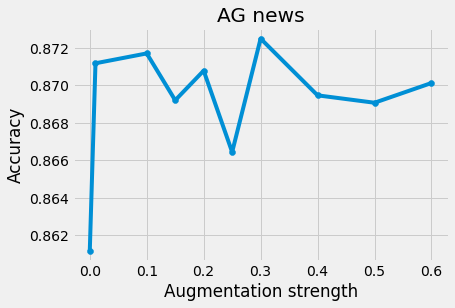

In [10]:
plt.plot(FRACTIONS, accuracies)
plt.scatter(FRACTIONS, accuracies)
plt.title('AG news')
plt.xlabel('Augmentation strength')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(ROOT_DIR, 'ag_100_mlm_insertion_strength.eps'), format='eps', bbox_inches='tight')